In [1]:
# =====================================================
# ENSEMBLE MODELS NOTEBOOK
# =====================================================

%run "./02_preprocessing.ipynb"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

print("Preprocessing loaded.")
print("X_train:", X_train.shape, " | X_test:", X_test.shape)


Initial shape: (15200, 15)
Exact duplicate rows: 192
Duplicate faculty_id: 8


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,promotion_opportunities,publications_last_3_years,student_evaluation_avg,left_institution
0,10000,Associate Professor,Tenure-Track,17,67410.138471,2,-2604.167089,Technical Institute,23,4,3,6,4,2.971100,0
1,10001,Full Professor,Non-Tenure,6,65578.523052,1,5601.080853,Technical Institute,8,6,6,6,6,3.681743,0
2,10002,Lecturer,Tenured,22,70730.493594,1,65860.624649,Technical Institute,11,9,1,7,9,1.002227,1
3,10003,Associate Professor,Tenured,0,59283.503256,4,41557.812521,Technical Institute,22,5,7,9,4,2.420985,0
4,10004,Associate Professor,Tenure-Track,26,66641.452922,5,26096.583217,Liberal Arts College,49,9,5,5,9,3.261318,0


Train shape: (12006, 13)
Test shape: (3002, 13)

Train target distribution:
left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'department_size', 'admin_support', 'work_life_balance', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg']
Preprocessor fitted successfully!
Processed shape: (12006, 34)
Preprocessor saved!
Preprocessing loaded.
X_train: (12006, 13)  | X_test: (3002, 13)


In [2]:
# =====================================================
# TRANSFORM TRAIN/TEST DATA ONCE
# =====================================================

# Apply preprocessor one time
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("Processed shapes:", X_train_processed.shape, X_test_processed.shape)


Processed shapes: (12006, 34) (3002, 34)


In [3]:
# =====================================================
# LOAD TRAINED MODELS (FULL PIPELINES)
# =====================================================

lr_full  = joblib.load("../models/log_reg.pkl")
svm_full = joblib.load("../models/svm_rbf.pkl")
rf_full  = joblib.load("../models/random_forest.pkl")
knn_full = joblib.load("../models/knn_svd.pkl")

print("All base models loaded successfully.")


# =====================================================
# EXTRACT ONLY THE CLASSIFIER PART FOR STACKING
# =====================================================

lr_clf  = lr_full.named_steps['lr']
svm_clf = svm_full.named_steps['svm']
rf_clf  = rf_full.named_steps['rf']

# KNN has SVD inside the pipeline → extract both
knn_svd = knn_full.named_steps['svd']
knn_clf = knn_full.named_steps['knn']

print("Extracted final estimators for stacking.")


All base models loaded successfully.
Extracted final estimators for stacking.


In [4]:
# =====================================================
# SOFT VOTING ENSEMBLE (Best Simple Ensemble)
# =====================================================

from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_full),
        ('svm', svm_full),
        ('rf', rf_full),
        ('knn', knn_full)
    ],
    voting='soft',
    weights=[1,1, 3, 2]   # Random Forest + SVM stronger
)

voting_clf.fit(X_train, y_train)

y_pred_vote = voting_clf.predict(X_test)
y_prob_vote = voting_clf.predict_proba(X_test)[:, 1]

print("Voting Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Voting AUC:", roc_auc_score(y_test, y_prob_vote))
print("\nVoting Report:\n", classification_report(y_test, y_pred_vote))


Voting Accuracy: 0.9556962025316456
Voting AUC: 0.910519002093846

Voting Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2283
           1       0.99      0.82      0.90       719

    accuracy                           0.96      3002
   macro avg       0.97      0.91      0.94      3002
weighted avg       0.96      0.96      0.95      3002



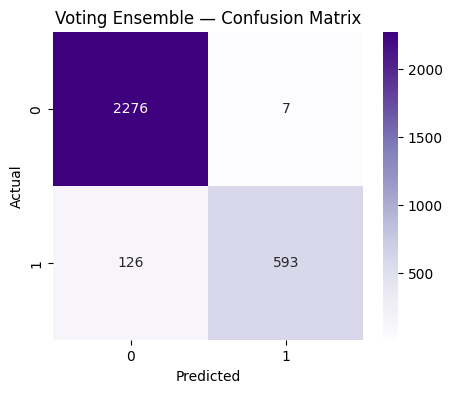

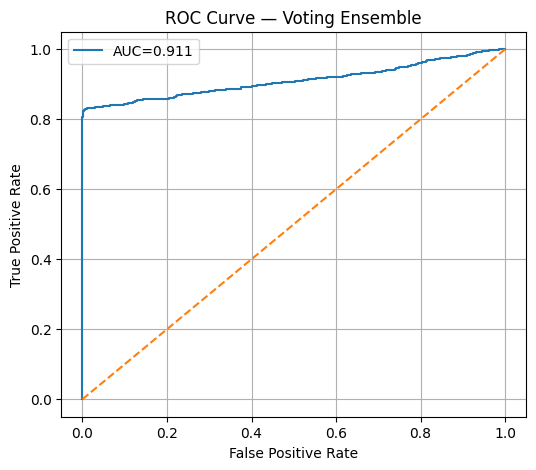

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Voting Ensemble — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_vote)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob_vote):.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Voting Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# =====================================================
# STACKING ENSEMBLE (Using Preprocessed Data)
# =====================================================

from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

stack_clf = StackingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('svm', svm_clf),
        ('rf', rf_clf),
        ('knn', knn_clf)
    ],
    final_estimator=GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
    passthrough=True,
    n_jobs=-1
)

# Train on processed data
stack_clf.fit(X_train_processed, y_train)


,estimators,"[('lr', ...), ('svm', ...), ...]"
,final_estimator,GradientBoost...ndom_state=42)
,cv,None
,stack_method,'auto'
,n_jobs,-1
,passthrough,True
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01


In [8]:
y_pred_stack = stack_clf.predict(X_test_processed)
y_prob_stack = stack_clf.predict_proba(X_test_processed)[:, 1]

print("Stacking Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking AUC:", roc_auc_score(y_test, y_prob_stack))
print("\nStacking Report:\n", classification_report(y_test, y_pred_stack))


Stacking Accuracy: 0.9573617588274483
Stacking AUC: 0.9097398257788564

Stacking Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2283
           1       0.99      0.83      0.90       719

    accuracy                           0.96      3002
   macro avg       0.97      0.91      0.94      3002
weighted avg       0.96      0.96      0.96      3002



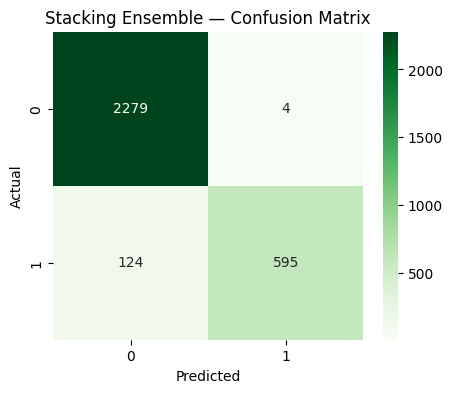

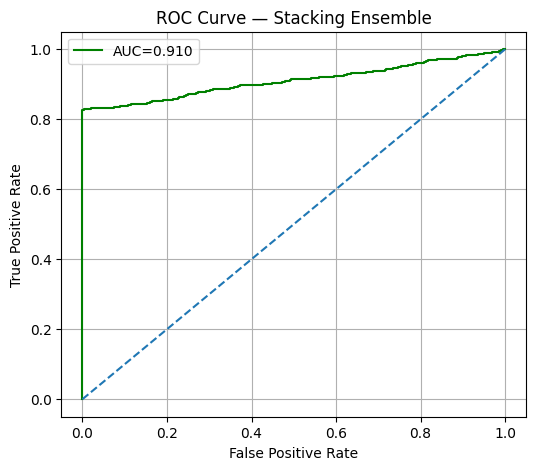

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Stacking Ensemble — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_stack)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='green', label=f"AUC={roc_auc_score(y_test, y_prob_stack):.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Stacking Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import joblib

joblib.dump(stack_clf, "../models/ensemble_voting.pkl")
print("Ensemble model saved!")

Ensemble model saved!
